# PPI power analysis



In [31]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
import os, sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ppi_py.datasets import load_dataset
from ppi_py.power_ppi import ppi_mean_power, ppi_ols_power, ppi_poisson_power
from ppi_py.ppi import ppi_mean_ci, ppi_ols_ci, ppi_poisson_ci
from tqdm import tqdm
from scipy.optimize import brentq
from scipy.stats import norm
from utils import *

## Import ballots data

In [33]:
dataset_folder = "./data/"
data = load_dataset(dataset_folder, "ballots")
Y = data["Y"]
Yhat = data["Yhat"]
Yhat_unlabeled = data["Yhat_unlabeled"]

## Perform initial power analysis with a subset of the data

In [34]:
n = Y.shape[0]
N = Yhat_unlabeled.shape[0]

n_initial = 200
N_initial = 200

labeled_initial = np.random.choice(n, n_initial, replace = False)
unlabeled_initial = np.random.choice(N, N_initial, replace = False)

Y_initial = Y[labeled_initial]
Yhat_initial = Yhat[labeled_initial]
Yhat_unlabeled_initial = Yhat_unlabeled[unlabeled_initial]
cost_Y = 1
cost_Yhat = 0.01

most_powerful_pair = ppi_mean_power(Y_initial, Yhat_initial, Yhat_unlabeled_initial, cost_Y, cost_Yhat, budget = 1000)
cheapest_pair = ppi_mean_power(Y_initial, Yhat_initial, Yhat_unlabeled_initial, cost_Y, cost_Yhat, se_tol = 0.01)
print("Most powerful pair:\n", most_powerful_pair)
print("Cheapest pair:\n", cheapest_pair)

Most powerful pair:
      n      N    cost       se  sigma_sq    rho_sq
0  706  28618  999.24  0.00509    0.2356  0.945104
Cheapest pair:
      n     N    cost       se  sigma_sq    rho_sq
0  182  7410  257.92  0.01002    0.2356  0.945104


In [35]:
n = most_powerful_pair["n"]
N = most_powerful_pair["N"]
sigma_sq = most_powerful_pair["sigma_sq"]
rho_sq = most_powerful_pair["rho_sq"]

print(n * (cost_Y + cost_Yhat) + N * cost_Yhat)
print((sigma_sq / n *(1 - N * rho_sq / (n+N)))**0.5)

0    999.24
dtype: float64
0    0.00509
dtype: float64


In [36]:
n_sub = most_powerful_pair['n'][0]
N_sub = most_powerful_pair['N'][0]

n = Y.shape[0]
N = Yhat_unlabeled.shape[0]
reps = 200 
ses = np.zeros(reps)
for i in range(reps):
    labeled_sample = np.random.choice(n, n_sub, replace = False)
    unlabeled_sample = np.random.choice(N, N_sub, replace = False)

    Y_sub = Y[labeled_sample]
    Yhat_sub = Yhat[labeled_sample]
    Yhat_unlabeled_sub = Yhat_unlabeled[unlabeled_sample]
    CI = ppi_mean_ci(Y_sub, Yhat_sub, Yhat_unlabeled_sub, alpha = 0.05)
    ses[i] = (CI[1][0] - CI[0][0])/norm.ppf(1 - 0.05/2)/2
    
print("Predicted SE for most powerful pair: ", most_powerful_pair['se'][0])
print("Estimated SE for most powerful pair: ", np.mean(ses))

Predicted SE for most powerful pair:  0.0050904459800778755
Estimated SE for most powerful pair:  0.004431664997296418


In [37]:
n_sub = cheapest_pair['n'][0]
N_sub = cheapest_pair['N'][0]

n = Y.shape[0]
N = Yhat_unlabeled.shape[0]
reps = 200 
ses = np.zeros(reps)
for i in range(reps):
    labeled_sample = np.random.choice(n, n_sub, replace = False)
    unlabeled_sample = np.random.choice(N, N_sub, replace = False)

    Y_sub = Y[labeled_sample]
    Yhat_sub = Yhat[labeled_sample]
    Yhat_unlabeled_sub = Yhat_unlabeled[unlabeled_sample]
    CI = ppi_mean_ci(Y_sub, Yhat_sub, Yhat_unlabeled_sub, alpha = 0.05)
    ses[i] = (CI[1][0] - CI[0][0])/norm.ppf(1 - 0.05/2)/2
    
print("Predicted SE for cheapest pair: ", cheapest_pair['se'][0])
print("Estimated SE for cheapest pair: ", np.mean(ses))

Predicted SE for cheapest pair:  0.010019578645392546
Estimated SE for cheapest pair:  0.008580211972035496


## Census income data (Regression estimation)


In [38]:
dataset_folder = "./data/"
data = load_dataset(dataset_folder, "census_income")
Y_total = data["Y"]
Yhat_total = data["Yhat"]
X_total = data["X"]

In [46]:
n_total = Y_total.shape[0]
d = X_total.shape[1]

n_initial = 500
N_initial = 500

sample = np.random.choice(n_total, n_initial + N_initial, replace = False)
Y_initial = Y_total[sample[:n_initial]]
Yhat_initial = Yhat_total[sample[:n_initial]]
X_initial = X_total[sample[:n_initial]]

Yhat_unlabeled_initial = Yhat_total[sample[n_initial:]]
X_unlabeled_initial = X_total[sample[n_initial:]]

cost_Y = 1
cost_Yhat = 0.01
cost_X = 0.01
coord = 0

most_powerful_pair = ppi_ols_power(X_initial, 
                                   Y_initial, 
                                   Yhat_initial,
                                   X_unlabeled_initial,
                                   Yhat_unlabeled_initial, 
                                   cost_Y, 
                                   cost_Yhat, 
                                   cost_X,
                                   coord,
                                   budget = 5000)
most_powerful_pair

,n,N,cost,se,sigma_sq,rho_sq
0,4659,12360,4999.38,35.707683,7.013193e+06,0.210627


In [47]:
n_sub = most_powerful_pair['n'][0]
N_sub = most_powerful_pair['N'][0]

reps = 100
ses = np.zeros(reps)
for i in range(reps):
    sample = np.random.choice(n_total, n_sub + N_sub, replace = False)
    Y_sub = Y_total[sample[:n_sub]]
    Yhat_sub = Yhat_total[sample[:n_sub]]
    X_sub = X_total[sample[:n_sub]]
    Yhat_unlabeled_sub = Yhat_total[sample[n_sub:]]
    X_unlabeled_sub = X_total[sample[n_sub:]]

    CI = ppi_ols_ci(X_sub, Y_sub, Yhat_sub, X_unlabeled_sub, Yhat_unlabeled_sub, alpha = 0.05, coord = coord)
    ses[i] = (CI[1][coord] - CI[0][coord])/norm.ppf(1 - 0.05/2)/2
    
    

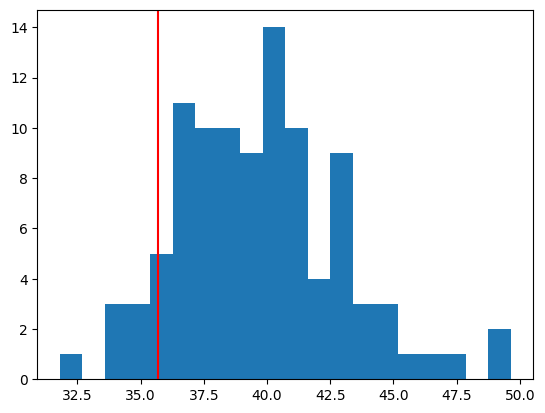

In [48]:
plt.hist(ses, bins = 20)
plt.axvline(most_powerful_pair['se'][0], color = 'red')
plt.show()

## Census education (Poisson regression)



In [49]:
dataset_folder = "./data/"
data = load_dataset(dataset_folder, "census_education")
Y_total = data["Y"]
Yhat_total = data["Yhat"]
X_total = data["X"]/10000 # scal

Dataset census_education not found at location ./data/; downloading now...


In [54]:
n_total = Y_total.shape[0]
d = X_total.shape[1]

n_initial = 500
N_initial = 500

sample = np.random.choice(n_total, n_initial + N_initial, replace = False)

Y_initial = Y_total[sample[:n_initial]]
Yhat_initial = Yhat_total[sample[:n_initial]]
X_initial = X_total[sample[:n_initial]]

Yhat_unlabeled_initial = Yhat_total[sample[n_initial:]]
X_unlabeled_initial = X_total[sample[n_initial:]]

cost_Y = 1
cost_Yhat = 0.01
cost_X = 0.01
coord = 0

most_powerful_pair = ppi_poisson_power(X_initial, 
                                       Y_initial, 
                                       Yhat_initial,
                                       X_unlabeled_initial,
                                       Yhat_unlabeled_initial, 
                                       cost_Y, 
                                       cost_Yhat, 
                                       cost_X,
                                       coord,
                                       budget = 5000)
most_powerful_pair

,n,N,cost,se,sigma_sq,rho_sq
0,4557,17564,4999.42,58.730273,2.107870e+07,0.320289


In [57]:
cheapest_pair = ppi_poisson_power(X_initial, 
                                Y_initial, 
                                Yhat_initial,
                                X_unlabeled_initial,
                                Yhat_unlabeled_initial, 
                                cost_Y, 
                                cost_Yhat, 
                                cost_X,
                                coord,
                                se_tol = 30)
cheapest_pair

,n,N,cost,se,sigma_sq,rho_sq
0,17464,67308,19159.44,30.000633,2.107870e+07,0.320289


In [58]:
n_sub = most_powerful_pair['n'][0]
N_sub = most_powerful_pair['N'][0]

reps = 100
ses = np.zeros(reps)
for i in range(reps):
    sample = np.random.choice(n_total, n_sub + N_sub, replace = False)
    Y_sub = Y_total[sample[:n_sub]]
    Yhat_sub = Yhat_total[sample[:n_sub]]
    X_sub = X_total[sample[:n_sub]]
    Yhat_unlabeled_sub = Yhat_total[sample[n_sub:]]
    X_unlabeled_sub = X_total[sample[n_sub:]]

    CI = ppi_poisson_ci(X_sub, Y_sub, Yhat_sub, X_unlabeled_sub, Yhat_unlabeled_sub, alpha = 0.05, coord = coord)
    ses[i] = (CI[1][coord] - CI[0][coord])/norm.ppf(1 - 0.05/2)/2
    
    

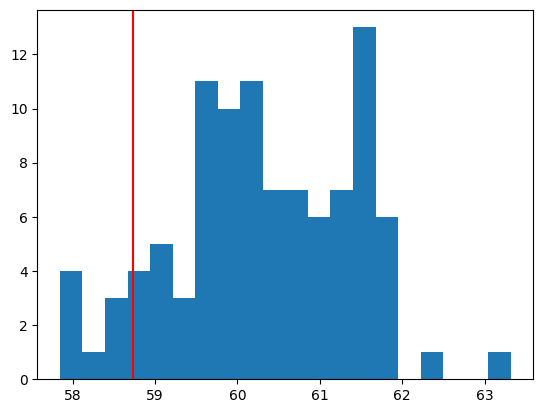

In [59]:
plt.hist(ses, bins = 20)
plt.axvline(most_powerful_pair['se'][0], color = 'red')
plt.show()